<a id='sec0'></a>
# Predictive annotation of quantification methods
Idea is to use the descriptive text for each dataset to predict which quantification method was used for the experiments for the dataset. Below is an outline for the process.<br>
- <a href='#sec1'><b>Data preparation</b></a>
- <a href='#sec2'><b>NLP</b></a>
- <a href='#sec3'><b>Classification (Initial)</b></a>
- <a href='#sec4'><b>Classification (Deeper)</b></a>

<a id='sec1'></a>
## Data preparation
<a href='#sec0'>(Back to top)</a><br>
1. Read in the DataFrame. <a href='#sec1-1'>jump</a><br>
    - Use only sample- & data-processing protocols, description, and quantification methods columns
    - apply .dropna() and see how many datasets remain
2. Decide on how many classes of quantification methods to create. <a href='#sec1-2'>jump</a><br>
    - Apply .lower() to everything
    - Pick top 4 or 5 and put others into other category.
    - Create dummy variables for the picked categories
    - Some data sets contain multiple quant methods, so I'll focus on binary classification for each dummy for now
3. Pre-process text fields for NLP. <a href='#sec1-3'>jump</a><br>
    - Follow nlp09 notebook as a guide
    - They all have to be processed the same way
    - Remove stop words, punctuation including brackets, non-aphanumericals
    - Lemmatize
4. Save processed data. <a href='#sec1-4'>jump</a><br>
    - Save DataFrame with dummies and pre-processed text
    - Create 5 sets of pre-processed text this will be used for creating dictionaries/models (e.g. BoW, Tf-Idf)
        - Sample preparation protocol only
        - Data processing protocol only
        - Description protocol only
        - Sample + data protocols
        - All fields combined
    - All to be saved under /serialized_data directory

In [1]:
import os
import pandas as pd
import numpy as np

<a id='sec1-1'></a>
#### 1. Read in data

In [2]:
# Read in the DataFrame
df = pd.read_csv('base_data/pride_table.csv',
                usecols=[
                    'dataset_id', 
                    'sample_protocol', 
                    'data_protocol',
                    'description',
                    'quant_methods'])

In [3]:
df.head()

,dataset_id,sample_protocol,data_protocol,description,quant_methods
0,PXD000001,Not available,Two extra files have been added post-publicati...,Expected reporter ion ratios: Erwinia peptides...,NaN
1,PXD000002,Not available,Not available,Human saliva samples from a 36 year old male w...,NaN
2,PXD000003,NaN,NaN,NaN,NaN
3,PXD000004,Not available,Not available,Prefrontal cortex tissue slices from a cogniti...,NaN
4,PXD000005,Not available,Not available,Proteomics on HCT116 cells. 3 samples wild-typ...,NaN


In [4]:
# Check how many datasets have valid entries
len(df), len(df.dropna()), len(df.quant_methods.dropna())

(5496, 2387, 2387)

So it appears that quant_methods are only specified for roughly half of the datasets. So just use those for now.

In [5]:
# dropna
df = df.dropna().reset_index(drop=True)

<a id='sec1-2'></a>
#### 2. Picking quantification methods

In [6]:
# .lower() all the quant methods
df.loc[:, 'quant_methods'] = df.quant_methods.str.lower()

# Figure out which quant methods are most pouplar
quant_methods_added_string = ','.join(list(df.quant_methods))
methods_strings = [method.strip() for method in quant_methods_added_string.split(',')]
methods_strings = pd.Series(methods_strings)

methods_strings.value_counts()[:10]

silac                                                   501
ms1 intensity based label-free quantification method    345
spectrum counting                                       328
tmt                                                     292
itraq                                                   274
label free                                              240
tic                                                     158
normalized spectral abundance factor - nsaf              96
peptide counting                                         48
empai                                                    33
dtype: int64

Let's try top 6 ('label free' and above) since they all appear at more than ~10% frequency
- silac
- ms1 intensity based label-free quantification method
- spectrum counting
- tmt
- itraq
- label free (this should be distinguished from 'label-free')

In [7]:
if False:
    df['silac'] = df.quant_methods.str.contains('silac').astype(int)
    df['ms1_label_free'] = df.quant_methods.str.contains('ms1 intensity based label-free quantification method').astype(int)
    df['spectrum_counting'] = df.quant_methods.str.contains('spectrum counting').astype(int)
    df['tmt'] = df.quant_methods.str.contains('tmt').astype(int)
    df['itraq'] = df.quant_methods.str.contains('itraq').astype(int)
    df['label_free'] = df.quant_methods.str.contains('label free').astype(int)

In [8]:
if False:
    df.head()

In [9]:
if False:
    df.to_csv('serialized_data/original_df_plus_dummies.csv', index=False)

<a id='sec1-3'></a>
#### 3. Process text fields

In [10]:
from nltk.corpus import stopwords
import spacy

In [11]:
# list of stop words
stop_words = stopwords.words('english')

# Import spacy model
nlp = spacy.load('en_core_web_lg')

In [12]:
def lemmatize_text(text):
    doc = nlp(text)
    lemm_text = [
            token.lemma_.lower() for token in doc 
            if token.text != '\u2009'
            if token.is_alpha
            if not token.is_stop
            if not token.is_punct
            if not token.is_bracket
            if not token.is_quote
            if token.pos_ != 'PRON'
            if token.tag_ != 'BES'
            if token.tag_ != 'IN'
            if token.tag_ != 'HVS'
            if token.tag_ != 'PDT'
            if token.tag_ != 'TO'
            if token.tag_ != 'UH'
            if token.text not in stop_words
            if len(token.text) > 1
    ]
    return lemm_text

In [13]:
%%time
if False:
    df.loc[:, 'sample_protocol'] = df.loc[:, 'sample_protocol'].apply(lambda x: lemmatize_text(x))
    df.loc[:, 'data_protocol'] = df.loc[:, 'data_protocol'].apply(lambda x: lemmatize_text(x))
    df.loc[:, 'description'] = df.loc[:, 'description'].apply(lambda x: lemmatize_text(x))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [14]:
if False:
    df.head()

<a id='sec1-4'></a>
#### 4. Save data 

In [15]:
import pickle

In [16]:
# Saving regular text corpora using pickle
# The combination ones are horizontal sum of two or three columns, so that
# the number of datasets won't change and label column can be used as is in the df
if False:
    # Save the processed DataFrame using pickle
    with open('serialized_data/processed_df_plus_dummies.pickle', 'wb') as out_df:
        pickle.dump(df, out_df)

    # Sample protocol
    with open('serialized_data/sample_protocol.pickle', 'wb') as outfile:
        pickle.dump(list(df.sample_protocol), outfile)

    # Data protocol
    with open('serialized_data/data_protocol.pickle', 'wb') as outfile:
        pickle.dump(list(df.data_protocol), outfile)

    # Protocols combined
    protocols = list(df.sample_protocol + df.data_protocol)
    with open('serialized_data/both_protocols.pickle', 'wb') as outfile:
        pickle.dump(protocols, outfile)

    # Description
    with open('serialized_data/description.pickle', 'wb') as outfile:
        pickle.dump(list(df.description), outfile)

    # All combined
    all = list(df.sample_protocol + df.data_protocol + df.description)
    with open('serialized_data/all_text_fields.pickle', 'wb') as outfile:
        pickle.dump(all, outfile)

<a id='sec2'></a>
## NLP
<a href='#sec0'>(Back to top)</a><br><br>
For now, only use BoW (counts) and Tf-Idf vectors. Some useless words can be potentially ommitted using feature_importance_ attribute of sklearn classifiers later, and then leaner dictionary could be used to create more informative, lower-dimensional feature space (hopefully).
1. Create a dictionary using the text set with all fields combined. <a href='#sec2-1'>jump</a><br>
2. Create BoWs for all text sets, save them. <a href='#sec2-2'>jump</a><br>
3. Create Tf-Idf for all text sets, save them. <a href='#sec2-3'>jump</a><br>

In [17]:
import gensim
from gensim import corpora, models

In [18]:
# Load serialized corpora
if False:
    # Sample protocol
    with open('serialized_data/sample_protocol.pickle', 'rb') as infile:
        sample_corpus = pickle.load(infile)

    # Data protocol
    with open('serialized_data/data_protocol.pickle', 'rb') as infile:
        data_corpus = pickle.load(infile)

    # Protocols combined
    with open('serialized_data/both_protocols.pickle', 'rb') as infile:
        protocols_corpus = pickle.load(infile)

    # Description
    with open('serialized_data/description.pickle', 'rb') as infile:
        description_corpus = pickle.load(infile)

    # All combined
    with open('serialized_data/all_text_fields.pickle', 'rb') as infile:
        whole_corpus = pickle.load(infile)

<a id='sec2-1'></a>
#### 1. Create dictionary 

In [19]:
# Create and save dictionary using whole_corpus
if False:
    my_dictionary = corpora.Dictionary(whole_corpus)
    my_dictionary.save('nlp13_data/whole_dictionary.dict')

<a id='sec2-2'></a>
#### 2. Create BoWs and save 

In [20]:
if False:
    # Convert to BoWs
    sample_bow = [dictionary.doc2bow(text) for text in sample_corpus]
    data_bow = [dictionary.doc2bow(text) for text in data_corpus]
    protocols_bow = [dictionary.doc2bow(text) for text in protocols_corpus]
    description_bow = [dictionary.doc2bow(text) for text in description_corpus]
    whole_bow = [dictionary.doc2bow(text) for text in whole_corpus]

    # Serialize BoWs
    corpora.MmCorpus.serialize('nlp13_data/sample_bow.mm', sample_bow)
    corpora.MmCorpus.serialize('nlp13_data/data_bow.mm', data_bow)
    corpora.MmCorpus.serialize('nlp13_data/protocol_bow.mm', protocols_bow)
    corpora.MmCorpus.serialize('nlp13_data/description_bow.mm', description_bow)
    corpora.MmCorpus.serialize('nlp13_data/whole_bow.mm', whole_bow)

<a id='sec2-3'></a>
#### 3. Create Tf_Idfs and save 

In [21]:
if False:
    # Create Tf-Idf models
    sample_tfidf_model = models.TfidfModel(sample_bow)
    data_tfidf_model = models.TfidfModel(data_bow)
    protocols_tfidf_model = models.TfidfModel(protocols_bow)
    description_tfidf_model = models.TfidfModel(description_bow)
    whole_tfidf_model = models.TfidfModel(whole_bow)
    
    # convert to Tf-Idf space
    sample_tfidf = sample_tfidf_model[sample_bow]
    data_tfidf = data_tfidf_model[data_bow]
    protocols_tfidf = protocols_tfidf_model[protocols_bow]
    description_tfidf = description_tfidf_model[description_bow]
    whole_tfidf = whole_tfidf_model[whole_bow]
    
    # Serialize Tf_Idfs
    corpora.MmCorpus.serialize('nlp13_data/sample_tfidf.mm', sample_tfidf)
    corpora.MmCorpus.serialize('nlp13_data/data_tfidf.mm', data_tfidf)
    corpora.MmCorpus.serialize('nlp13_data/protocols_tfidf.mm', protocols_tfidf)
    corpora.MmCorpus.serialize('nlp13_data/description_tfidf.mm', description_tfidf)
    corpora.MmCorpus.serialize('nlp13_data/whole_tfidf.mm', whole_tfidf)
    
    # Check sizes of each corpus
    len(sample_tfidf), len(data_tfidf), len(protocols_tfidf), len(description_tfidf), len(whole_tfidf)

<a id='sec3'></a>
## Classification (initial)
<a href='#sec0'>(Back to top)</a><br><br>
<i>Here, I'll focus on binary classification for each category. For example, one task would be to distinguish 'silac' from everything else. Ideally, it should be multi-class classification, but since a dataset can contain multiple quantification methods, for now, I'll stick with yes/no type binary classification for each quantification method that I picked. Here, I'll use Tf-Idf vectors only and take a quick look at the performance of different classifiersvisually with ROC curves. </i><br>
<br>
Classifiers to try: MultinomialNB, Logistic Regression, Random Forest (and SVM maybe?)<br>
<br>
For each classifier for each text set for each type of word vectors for each quantification type:
1. Split into train/test with a fixed random_state for comparison
2. Run vanilla classifier without much hyperparameter tuned and plot ROC curves

#### Loading data

In [22]:
if True:
    with open('serialized_data/processed_df_plus_dummies.pickle', 'rb') as out_df:
        df =pickle.load(out_df)
    
    sample_tfidf = corpora.MmCorpus('nlp13_data/sample_tfidf.mm')
    data_tfidf = corpora.MmCorpus('nlp13_data/data_tfidf.mm')
    protocols_tfidf = corpora.MmCorpus('nlp13_data/protocols_tfidf.mm')
    description_tfidf = corpora.MmCorpus('nlp13_data/description_tfidf.mm')
    whole_tfidf = corpora.MmCorpus('nlp13_data/whole_tfidf.mm')

#### Import modules

In [23]:
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

In [25]:
if True:
    my_dictionary = corpora.Dictionary.load('nlp13_data/whole_dictionary.dict')
    print(my_dictionary)

Dictionary(22736 unique tokens: ['-pron-', 'activation', 'aggressive', 'alkylation', 'also']...)


In [26]:
def classify(corpus, target, num_terms=22736, test_size=0.2, random_state=777):
    # Set features and y
    x = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    # Classifiers to test
    classifiers = {
    'MultinomialNB': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
    }

    results = {}
    for name, clf in classifiers.items():
        result = {}
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        report = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['report'] = report
        result['fpr'] = fpr
        result['tpr'] = tpr
        results[name] = result
    return results


def multiple_classify(my_corpora, target, target_labe=None, num_terms=22736, test_size=0.2, random_state=777):
    fig = plt.figure(figsize=(12, 8))
    t = np.linspace(0, 1, 10)
    ax_pos = 1

    for corpus_name, corpus in my_corpora.items():
        results = classify(corpus, target, num_terms=22736)

        ax = fig.add_subplot(2, 3, ax_pos)
        ax.plot(t, t, ls='--', lw=0.5, color='0.4')
        for k, v in results.items():
            #print('='*5, 'Report for %s' % k, '='*10)
            #print(v['report'])
            fpr = v['fpr']
            tpr = v['tpr']
            ax.plot(fpr, tpr, label=k)
        ax.legend()
        ax.set_xlabel('False Positive Rate')#, fontsize=14)
        ax.set_ylabel('True Positive Rate')#, fontsize=14)
        a = ax.set_title('Annotating \'%s\'\nby %s' % (target_labe, corpus_name))#, fontsize=14)
        ax_pos += 1

    fig.tight_layout()

In [27]:
my_corpora = {
    'sample_protocol': sample_tfidf,
    'data_protocol': data_tfidf,
    'both_protocols': protocols_tfidf,
    'description': description_tfidf,
    'all_combined': whole_tfidf
}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Pre

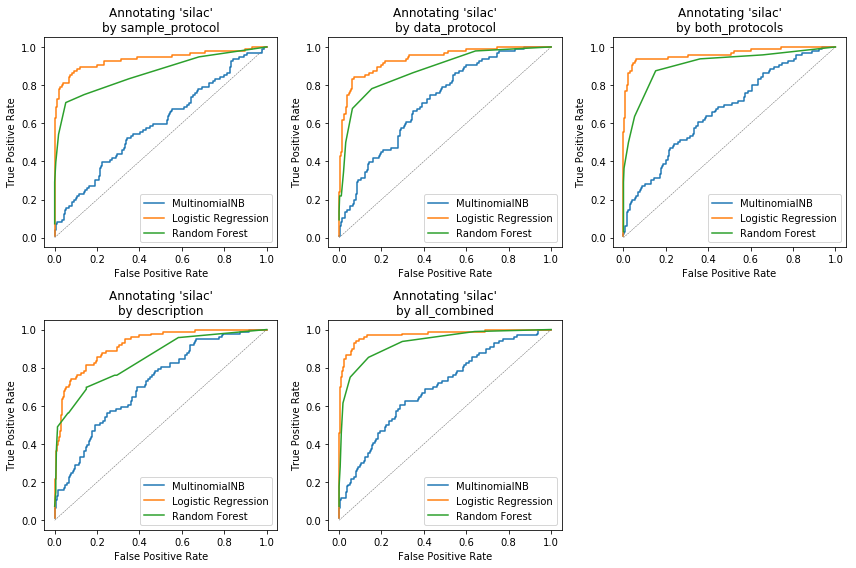

In [28]:
multiple_classify(my_corpora, df.silac, target_labe='silac', num_terms=22736, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Pre

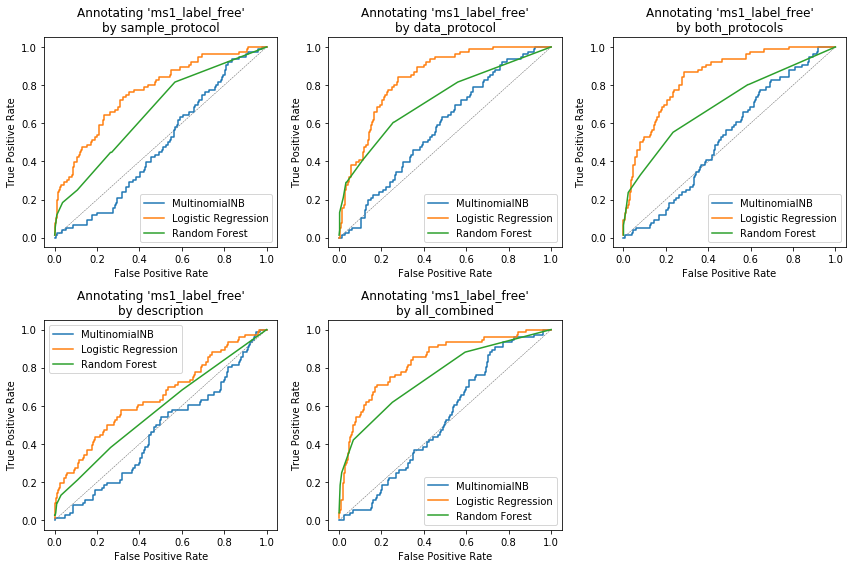

In [29]:
multiple_classify(my_corpora, df.ms1_label_free, target_labe='ms1_label_free', num_terms=22736, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Pre

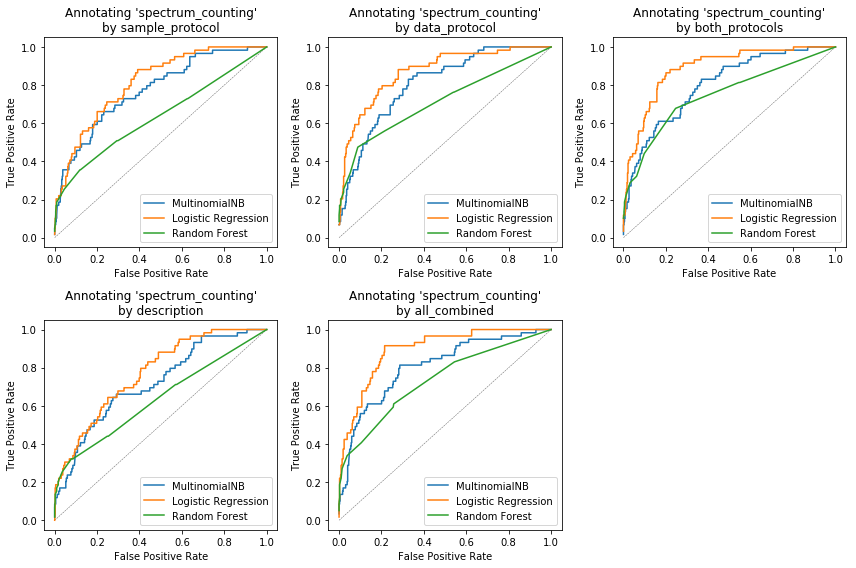

In [30]:
multiple_classify(my_corpora, df.spectrum_counting, target_labe='spectrum_counting', num_terms=22736, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Pre

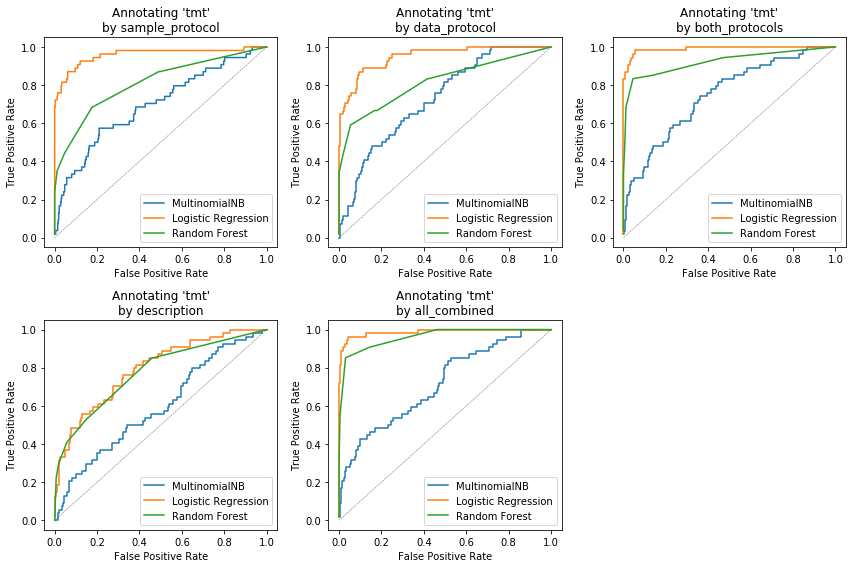

In [31]:
multiple_classify(my_corpora, df.tmt, target_labe='tmt', num_terms=22736, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Pre

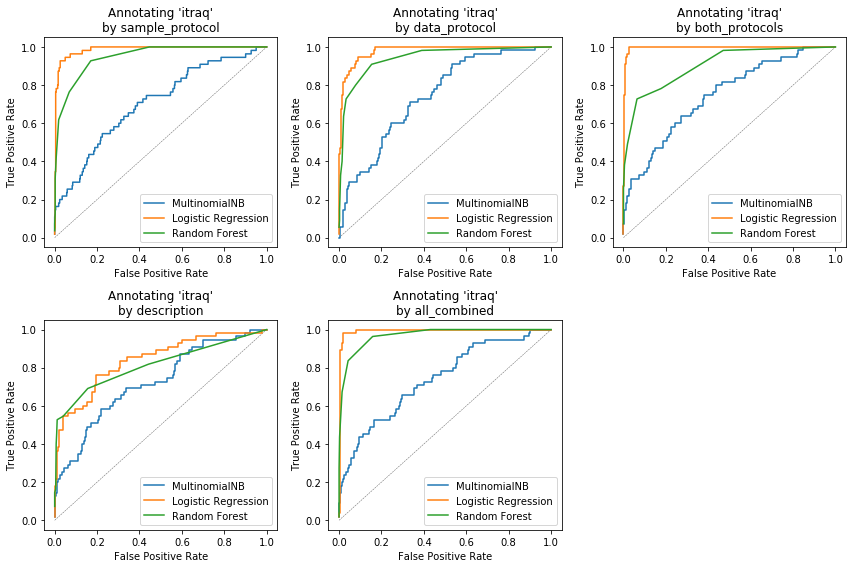

In [32]:
multiple_classify(my_corpora, df.itraq, target_labe='itraq', num_terms=22736, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Pre

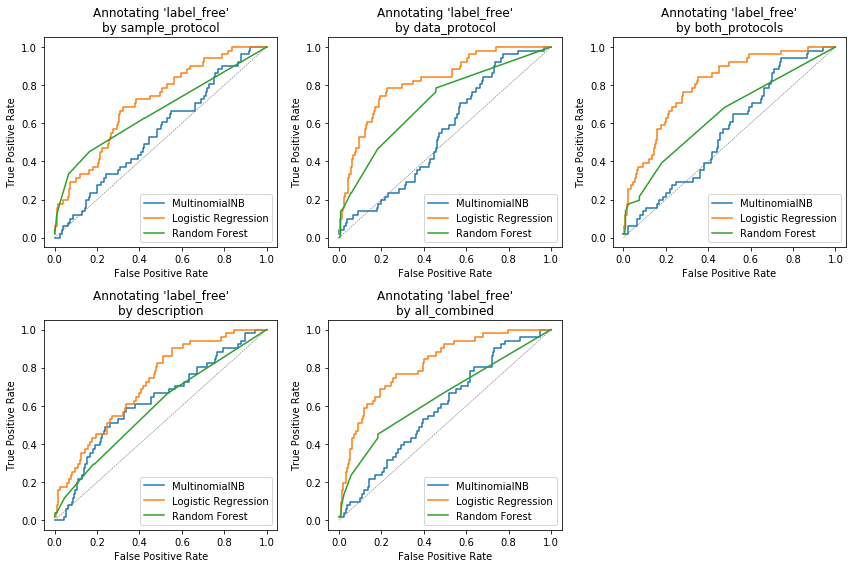

In [33]:
multiple_classify(my_corpora, df.label_free, target_labe='label_free', num_terms=22736, test_size=0.2, random_state=777)

<i>They actually look very good though the prediction process is quite quick and dirty! It appears combination of sample- and data-processing protocols, as well as its combination with the description field, perform well. As for the classifiers, Naive Bayes performed quite poorly, while Logistic Regression performed best. I can focus on LR and do proper CV and assessements next. Here, all the words were used (i.e. num_terms=(number of unique tokens in the dictionary)), however, that is quite likely unnecessary so columns should be systematically eliminated. Hyperparameters will be tuned too.</i>

<a id='sec4'></a>
## Classification (deeper dig)
<a href='#sec0'>(Back to top)</a><br><br>
Looks like automatic annotation is quite possible for most quantification methods! 'Description' appear not so useful as the protocol fields. Here I'll focus on both_protocols corpora (and maybe whole_corpus too) and assess the classification more properly.<br>
<br>
Classifiers to use: Logistic Regression only because it looked good!<br>
<br>
For each classifier for each text set for each type of word vectors for each quantification type:<br>
1. Put features and target labels in 4~5 CV fold
2. Run vanilla classifier without much hyperparameter tuned and collect:
    - accuracy
    - precision, recall, & F1
    - precision_recall curve
    - average_precision_score
    - fpr, tpr, roc_curve, roc_auc
    - brier loss
    - feature importances (for RF)
3. Tabukate and plot results